In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import os
import pandas as pd
#import importlib
from matplotlib.patches import Rectangle

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')



# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses_single = Masses.groupby('A').apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0_single = Masses_single['A'].to_numpy()
Z0_single = Masses_single['Z'].to_numpy()
N0_single = Masses_single['N'].to_numpy()
Element_single = Masses_single['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0_single = Masses_single['Ebinding'].to_numpy()

Energies_unc0_single = Masses_single['E_unc'].to_numpy()




# extract 3 nucleon around maximum
Masses_triple = Masses.sort_values(['A','Ebinding'],ascending=False).groupby('A').head(3)

A0_triple = Masses_triple['A'].to_numpy()
Z0_triple = Masses_triple['Z'].to_numpy()
N0_triple = Masses_triple['N'].to_numpy()
Element_triple = Masses_triple['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0_triple = Masses_triple['Ebinding'].to_numpy()

Energies_unc0_triple = Masses_triple['E_unc'].to_numpy()

In [3]:
print(Energies0_single[10:30:1])

[8.03224  7.971713 8.080465 8.111493 8.260709 8.223502 8.33387  8.331553
 8.447744 8.448635 8.520654 8.481167 8.493129 8.513806 8.583498 8.53785
 8.575389 8.570281 8.61428  8.562598]


In [4]:
# define parameter space

#[ 15.83409612 -18.37376576  -0.71762294 -23.49108417  13.13352343]

#theta_0_vals = np.linspace(a_limits[0,0], a_limits[0,1], 100)
#theta_1_vals = np.linspace(a_limits[1,0], a_limits[1,1], 100)
#theta_2_vals = np.linspace(a_limits[2,0], a_limits[2,1], 100)

'''theta_0_bound = np.array([10, 30]).reshape(1,-1)
theta_1_bound = np.array([-20, 0]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)
theta_3_bound = np.array([-30, -10]).reshape(1,-1)
theta_4_bound = np.array([0, 30]).reshape(1,-1)'''

theta_0_bound = np.array([0, 40]).reshape(1,-1)
theta_1_bound = np.array([-40, 10]).reshape(1,-1)
theta_2_bound = np.array([-3, 3]).reshape(1,-1)
theta_3_bound = np.array([-50, 0]).reshape(1,-1) # keep
theta_4_bound = np.array([-10, 40]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound), axis=0)


#theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)


In [5]:
def LiquidDropModel(params, A, Z, N):

    
    if len(params) == 4:
        a1, a2, a3, a4 = params
        EB = (a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A)
        return EB/A
    else:
        a1, a2, a3, a4, a5 = params
        EB = (a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A + a5*( (-1)**Z + (-1)**N )*(2*A**(-0.5)))
        return EB/A
    
    
    

In [6]:
def create_model_error(_A):
    
    sigma_model = np.zeros(len(_A))     
        
    for i in range(len(_A)):
        if _A[i] < 40:
            sigma_model[i] = 0.09


        elif _A[i] < 140:
            sigma_model[i] = 0.05

        elif _A[i] < 200:
            sigma_model[i] = 0.04
        else:
            sigma_model[i] = 0.02
            
    return sigma_model


In [7]:
# define observational data
# pass in array of obs data for each wave

# wave 1 - A < 40
obs_data_wave1 = Energies0_single[10:30:2]
A_wave1 = A0_single[10:30:2]
Z_wave1 = Z0_single[10:30:2]
N_wave1 = N0_single[10:30:2]
variables_wave1 = np.concatenate((A_wave1.reshape(-1,1),Z_wave1.reshape(-1,1),\
                            N_wave1.reshape(-1,1)), axis=1)

sigma_obs_wave1 = Energies_unc0_single[10:30:2]
sigma_model_wave1 = create_model_error(A_wave1)



# wave 2 - A < 140
obs_data_wave2 = Energies0_single[10:130:3]
A_wave2 = A0_single[10:130:3]
Z_wave2 = Z0_single[10:130:3]
N_wave2 = N0_single[10:130:3]
variables_wave2 = np.concatenate((A_wave2.reshape(-1,1),Z_wave2.reshape(-1,1),\
                            N_wave2.reshape(-1,1)), axis=1)

sigma_obs_wave2 = Energies_unc0_single[10:130:3]
sigma_model_wave2 = create_model_error(A_wave2)

# wave 3 - A < 200
obs_data_wave3 = Energies0_single[10:190:3]
A_wave3 = A0_single[10:190:3]
Z_wave3 = Z0_single[10:190:3]
N_wave3 = N0_single[10:190:3]
variables_wave3 = np.concatenate((A_wave3.reshape(-1,1),Z_wave3.reshape(-1,1),\
                            N_wave3.reshape(-1,1)), axis=1)

sigma_obs_wave3 = Energies_unc0_single[10:190:3]
sigma_model_wave3 = create_model_error(A_wave3)

# wave 4 - A > 200
obs_data_wave4 = Energies0_single[10:-1:3]
A_wave4 = A0_single[10:-1:3]
Z_wave4 = Z0_single[10:-1:3]
N_wave4 = N0_single[10:-1:3]
variables_wave4 = np.concatenate((A_wave4.reshape(-1,1),Z_wave4.reshape(-1,1),\
                            N_wave4.reshape(-1,1)), axis=1)

sigma_obs_wave4 = Energies_unc0_single[10:-1:3]
sigma_model_wave4 = create_model_error(A_wave4)

'''
# wave 5 - A > 200
obs_data_wave5 = Energies0_single[10:-1:3]
A_wave5 = A0_single[10:-1:3]
Z_wave5 = Z0_single[10:-1:3]
N_wave5 = N0_single[10:-1:3]
variables_wave5 = np.concatenate((A_wave5.reshape(-1,1),Z_wave5.reshape(-1,1),\
                            N_wave5.reshape(-1,1)), axis=1)

sigma_obs_wave5 = Energies_unc0_single[10:-1:3]
sigma_model_wave5 = create_model_error(A_wave5)


'''

# wave 5 - introduce ap - all data such that 3 points around E minimum are captured
obs_data_wave5 = np.flip(Energies0_triple)[30:-1:4]
A_wave5 = np.flip(A0_triple)[30:-1:4]
Z_wave5 = np.flip(Z0_triple)[30:-1:4]
N_wave5 = np.flip(N0_triple)[30:-1:4]
variables_wave5 = np.concatenate((A_wave5.reshape(-1,1),Z_wave5.reshape(-1,1),\
                            N_wave5.reshape(-1,1)), axis=1)

sigma_obs_wave5 = np.flip(Energies_unc0_triple)[30:-1:4]
sigma_model_wave5 = create_model_error(A_wave5)


obs_data = [obs_data_wave1, obs_data_wave2, obs_data_wave3, obs_data_wave4, obs_data_wave5, obs_data_wave5]
sigma_obs = [sigma_obs_wave1, sigma_obs_wave2, sigma_obs_wave3, sigma_obs_wave4, sigma_obs_wave5, sigma_obs_wave5]
sigma_model = [sigma_model_wave1, sigma_model_wave2, sigma_model_wave3, sigma_model_wave4, sigma_model_wave5, sigma_model_wave5]

variables = [variables_wave1, variables_wave2, variables_wave3, variables_wave4, variables_wave5, variables_wave5]


In [8]:
for i in range(len(obs_data)):
    print(obs_data[i].shape)

(10,)
(40,)
(60,)
(83,)
(182,)
(182,)


In [9]:
#indep_var = [1, (A**(2.0/3.0))/A, Z*(Z-1)*(A**(-1.0/3.0))/A, \
                 #((N-Z)**2)/(A**2), ( (-1)**Z + (-1)**N )/(A*(2*A**(0.5)))]

def design_matrix(ndim):
    # design matrix X
    X = np.zeros((len(A),ndim))
    for i in range(ndim):
        X[:,i] = indep_var[i]
    return X

In [10]:

#clf = skl.LinearRegression(fit_intercept=False).fit(design_matrix(5), obs_data_wave5)

#print(clf.coef_)

#preds = clf.predict(design_matrix(5))


#err = np.sum(np.square(obs_data-preds))

#pred_sigma = np.sqrt(err / (len(obs_data) - 5)) 

#https://stats.stackexchange.com/questions/284772/estimator-of-variance-of-error
#sigma_model = [3*pred_sigma,2*pred_sigma,pred_sigma]

# from literature:
# < 40: 11 % : 0.9
# < 140: 1.5% : 0.12 
# < 200: 0.8% : 0.07
# > 200: 0.2% : 0.015

# 

#0.48701777858568074
#0.11367774024287203
#0.022425586162559498
#0.010242804230700025
#0.02090108740757404

In [11]:
volshapes = ['gaussian', 'hypercube', 'hypercube_rot', 'ellipsoid']

In [12]:
nwaves = 5
ndim = 5
nsamples = 1 * (10**5)
volshape = 'ellipsoid'

In [13]:
#importlib.reload(historymatch)

# initialise history matching class
HM = historymatch.HistoryMatch(ndim, 'GP', volshape)

In [14]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(LiquidDropModel)

#[7,40,60]
HM.set_observations(obs_data, variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model, inactive_wave = 4, sigma_inactive = 0.02)
HM.initialize_volume(parameter_bounds[:,0], parameter_bounds[:,1], ninactive=1)

#results = HM.run(nwaves=nwaves)

results = HM.wave(obs_data[0][:2], sigma_obs[0][:2], sigma_model[0][:2], variables[0], nsamples=nsamples, ntraining=100)

0


100%|██████████| 2/2 [00:03<00:00,  1.82s/it]

Number of Non-Implausible Samples: (2200, 5)


[ 13.37199018 -14.93865068   0.13788005 -25.64451318]


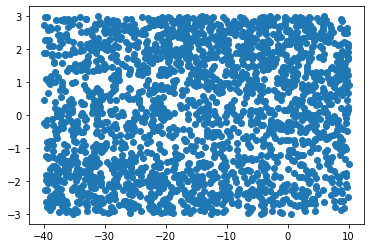

In [15]:
fig, ax = plt.subplots()
ax.scatter(results[0][:,1],results[0][:,2])
print(np.mean(results[0][:,:-1], axis=0))

In [16]:
results_w2 = HM.wave(obs_data[1][:2], sigma_obs[1][:2], sigma_model[1][:2], variables[1], nsamples=nsamples)

(4, 4)
1


100%|██████████| 2/2 [00:03<00:00,  1.86s/it]

Number of Non-Implausible Samples: (86066, 5)


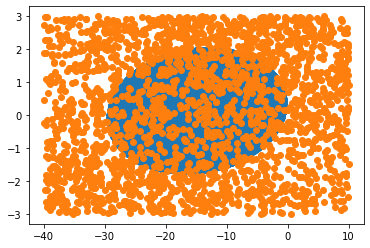

In [20]:
fig, ax = plt.subplots()
ax.scatter(results_w2[1][:,1],results_w2[1][:,2])
ax.scatter(results[0][:,1],results[0][:,2])

In [18]:
analytic_mean = np.loadtxt("data/5D_analytic_mean_final.txt").reshape(ndim,)
analytic_cov = np.loadtxt("data/5D_analytic_cov_final.txt").reshape(ndim,ndim)

In [19]:
#importlib.reload(plot)

colors = ['sandybrown', 'gold', 'yellowgreen', 'mediumseagreen', 'turquoise', 'cornflowerblue', 'mediumpurple', 'plum', 'lightpink', ]
theta_names = [r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{a}$', r'$a_{P}$']

sample_bounds = utils.locate_boundaries(results.samples[-1], 4)
tempbounds = np.concatenate((sample_bounds[-1].reshape(-1,1),sample_bounds[-1].reshape(-1,1)),axis=1).T

#true = clf.coef_
#true = [15.92808016, -18.53454643,  -0.72795844, -23.73239355,]

fig, axes = plt.subplots(ndim, ndim, figsize=(15,15))

if volshape == 'gaussian':
    for k in range(0,nwaves):
        
        if k < 4:
            dims = 4
        else:
            dims = 5
        
        nonimplausible_scaled = np.zeros_like(results.nonimplausible[k])
        for dim in range(dims):
            nonimplausible_scaled[:,dim] = results.nonimplausible[k][:,dim]
        mean = np.mean(nonimplausible_scaled[:,:-1].T, axis=1)
        cov = np.cov(nonimplausible_scaled[:,:-1].T)
        print(cov.shape)
        
        for i in range(dims):
            for j in range(dims):
                
                ax = axes[j,i]
                if i < j:
                    true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    cov_matrix = np.array([[cov[i,i], cov[i,j]],[cov[j,i], cov[j,j]]])
                    plot.get_cov_ellipse(cov_matrix, [mean[i],mean[j]], 3, 5.991, ax, colors[k], '-')
                    plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black', '-')
                    
                    #ax.scatter(results.samples[1][:,i], results.samples[1][:,j], color=colors[4])
                    #ax.scatter(results.nonimplausible[0][:,i], results.nonimplausible[0][:,j], color=colors[0])
                    #ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    #ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    #ax.scatter(true[i],true[j])
                    ax.set_xlabel(theta_names[i])
                    ax.set_ylabel(theta_names[j])
                elif i == j:
                    #ax.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], mean[i], np.sqrt(cov[i,i])), color='plum')
                    ax.set_xlim([sample_bounds[i][0],sample_bounds[i][1]])
                    #ax.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                else:
                    ax.axis('off')
elif volshape == 'hypercube':
    for k in range(nwaves):
        
        if k < 4:
            ndim = 4
        else:
            ndim = 5
            
        nonimplausible = np.zeros_like(results.nonimp_bounds[k])
        for dim in range(ndim):
            nonimplausible[dim] = results.nonimp_bounds[k][dim]
            
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    ax.add_patch(Rectangle((nonimplausible[i,0], nonimplausible[j,0]),\
                                           (nonimplausible[i,1]-nonimplausible[i,0]), \
                                           (nonimplausible[j,1]-nonimplausible[j,0]),\
                        color=colors[k],alpha=0.7,label='Nonimp. Hypercube'))
                    plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black', linestyle='-')
                    ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    ax.set_xlabel(theta_names[i])
                    ax.set_ylabel(theta_names[j])
                else:
                    ax.axis('off')

AttributeError: 'tuple' object has no attribute 'samples'

In [ ]:
fig, ax = plt.subplots()
ax.scatter(results.nonimplausible[-1][:,0], results.nonimplausible[-1][:,1])

for i in range(len(obs_data)):
    params = results.nonimplausible[-1][9][:5]
    print(params)
    ymodel = LiquidDropModel(params, A0[i], Z0[i], N0[i])
    print(ymodel-obs_data[i])
    print()
    print(sigma_model[i])
    print(HM.implausibility(ymodel, obs_data[i], 0, 0, sigma_model[i]**2, 0))
    print('---')

In [ ]:
true_coef = [15.52975475+1, -17.49796403, -0.69485949, -22.718944, 14.52745834]
print(LiquidDropModel(true_coef, A[0], Z[0], N[0]))

true_coef = [15.52975475, -17.49796403, -0.69485949, -22.718944, 14.52745834]
print(LiquidDropModel(true_coef, A[82], Z[82], N[82]))

In [ ]:
'''fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

#ax.scatter(samples_scaled[:,0], samples_scaled[:,1], samples_scaled[:,2], s=10, color='gold', alpha=0.1, label='Nonimplausible Samples')
ax.scatter(nonimplausible_scaled[:,0], nonimplausible_scaled[:,1], nonimplausible_scaled[:,2], s=20, color='red', label='Nonimplausible Samples')
ax.scatter(true[0],true[1],true[2])
#ax.view_init(0, 90)'''

In [ ]:
dictionary = {'Nsamples : ' : len(results.samples[0]), 'Noutputs : ' : len(obs_data)}

keys = np.array(['Nsamples', 'Noutputs']).reshape(1,-1)
vals = np.array([len(results.samples[0]), len(obs_data)]).reshape(1,-1)

In [ ]:
'''
shape = volshape
for wave in range(nwaves):
    file = open("data/w{}_{}_nonimp.txt".format(wave+1,shape), "w")
    np.savetxt(file, results.nonimplausible[wave])
    file.close()
    file3 = open("data/w{}_{}_samples.txt".format(wave+1,shape), "w")
    np.savetxt(file3, results.I_samples[wave])
    file3.close()
file2 = open("data/details_{}.txt".format(shape), "w")
np.savetxt(file2, keys, fmt="%s")
np.savetxt(file2, vals, fmt="%d")
file2.close()'''